In [1]:
##### Import packages
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Other packages
from random import sample

# To avoid warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
##### Functions

# Percentile function for agregate
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [3]:
##### Import data
# Check the csv's path before running it

dfx = pd.read_csv('accs_x.csv', names=['id_','time_ref','value_acc_x'], header=0)
dfy = pd.read_csv('accs_y.csv', names=['id_','time_ref','value_acc_y'], header=0)
dfz = pd.read_csv('accs_z.csv', names=['id_','time_ref','value_acc_z'], header=0)
df_energy = pd.read_csv('energy.csv')

In [4]:
##### Quick check of each dataset

# x-axis accelerometry
print(f' accs_x '.center(50,'#'))
print(dfx.info())
print(dfx.describe())
print(' ')

# y-axis accelerometry
print(f' accs_y '.center(50,'#'))
print(dfy.info())
print(dfy.describe())
print(' ')

# z-axis accelerometry
print(f' accs_z '.center(50,'#'))
print(dfz.info())
print(dfz.describe())
print(' ')

# energy associated with accelerometry and heart rate per time interval
print(f' energy '.center(50,'#'))
print(df_energy.info())
print(df_energy.describe())
print(' ')

##################### accs_x #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459482 entries, 0 to 1459481
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id_          1459482 non-null  int64  
 1   time_ref     1459482 non-null  object 
 2   value_acc_x  1459482 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 33.4+ MB
None
                id_   value_acc_x
count  1.459482e+06  1.459482e+06
mean   7.005000e+02  2.818822e-02
std    4.047226e+02  5.459730e-01
min    0.000000e+00 -3.748779e+00
25%    3.500000e+02 -2.980957e-01
50%    7.005000e+02 -2.484131e-02
75%    1.051000e+03  4.101562e-01
max    1.401000e+03  8.987549e+00
 
##################### accs_y #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459482 entries, 0 to 1459481
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------  

In [5]:
##### Format change to datetime on some energy columns

for col in ['date_Hr', 'startDate_energy', 'endDate_energy']:
    df_energy[col] = pd.to_datetime(df_energy[col])

# Creation of major variables

In [6]:
##### I create the variable 'jerk' which is the derivative of the acceleration.
# To do it properly, I do an approximation using the variable as discrete and assuming that the intervals of time are constant
# The acceleration is a vector, and therefore its derivative also has vectorial character.
# Then, I calculate the partial derivatives with respect to each axis.

dfx["jerk_x"]= dfx["value_acc_x"] - dfx.groupby("id_")["value_acc_x"].shift(-1)
dfy["jerk_y"] = dfy["value_acc_y"] - dfy.groupby("id_")["value_acc_y"].shift(-1)
dfz["jerk_z"] = dfz["value_acc_z"] - dfz.groupby("id_")["value_acc_z"].shift(-1)

dfx.drop(dfx.loc[dfx.jerk_x != dfx.jerk_x].index, inplace=True)
dfy.drop(dfy.loc[dfy.jerk_y != dfy.jerk_y].index, inplace=True)
dfz.drop(dfz.loc[dfz.jerk_z != dfz.jerk_z].index, inplace=True)

dfx.head()

,id_,time_ref,value_acc_x,jerk_x
0,0,accx_minus_0000,-0.837891,0.012695
1,0,accx_minus_0001,-0.850586,-0.015137
2,0,accx_minus_0002,-0.835449,0.004395
3,0,accx_minus_0003,-0.839844,0.002441
4,0,accx_minus_0004,-0.842285,0.002441


In [7]:
##### I put together the information from the three axes in order to get more information.
# I create the acceleration module and jerk module variables, which are scalar magnitudes with crucial information 
# about the activity and I assumed that are relevant to the model.

dfx.time_ref = dfx.time_ref.apply(lambda x: x[x.rfind("_")+1:])
dfy.time_ref = dfy.time_ref.apply(lambda x: x[x.rfind("_")+1:])
dfz.time_ref = dfz.time_ref.apply(lambda x: x[x.rfind("_")+1:])

df_acc = pd.merge(pd.merge(dfx,dfy,how="inner",on=['id_', 'time_ref']),dfz,how="inner",on=['id_', 'time_ref'])

df_acc["mod_acc"] = np.sqrt((df_acc.value_acc_x**2) + (df_acc.value_acc_y**2) + (df_acc.value_acc_z**2))
df_acc["mod_jerk"] = np.sqrt((df_acc.jerk_x**2) + (df_acc.jerk_y**2) + (df_acc.jerk_z**2))

df_acc.head()

,id_,time_ref,value_acc_x,jerk_x,value_acc_y,jerk_y,value_acc_z,jerk_z,mod_acc,mod_jerk
0,0,0000,-0.837891,0.012695,0.300049,0.002930,-0.437500,0.010742,0.991714,0.016886
1,0,0001,-0.850586,-0.015137,0.297119,-0.012695,-0.448242,0.002686,1.006329,0.019937
2,0,0002,-0.835449,0.004395,0.309814,-0.012207,-0.450928,-0.008545,0.998647,0.015535
3,0,0003,-0.839844,0.002441,0.322021,0.044678,-0.442383,-0.023438,1.002366,0.050511
4,0,0004,-0.842285,0.002441,0.277344,-0.007324,-0.418945,0.016113,0.980754,0.017867


# Exploratory Data Analysis

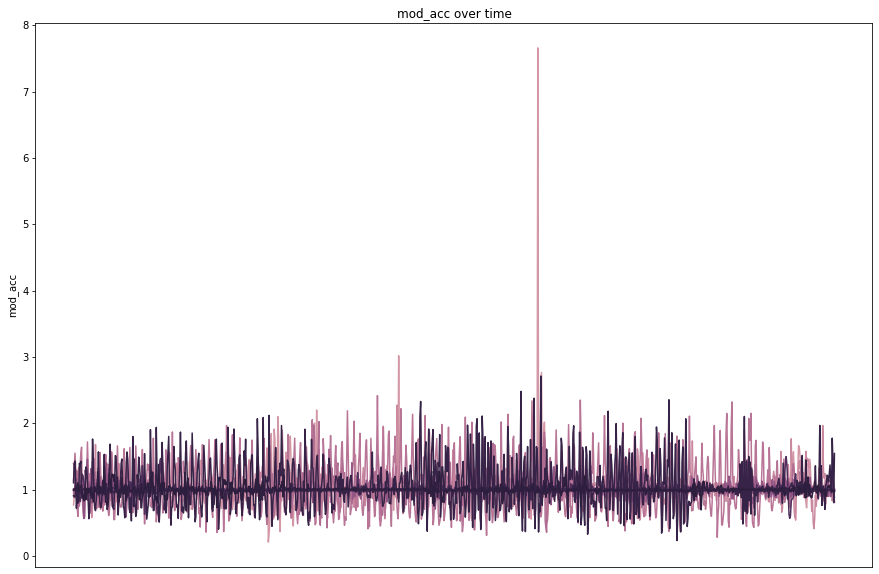

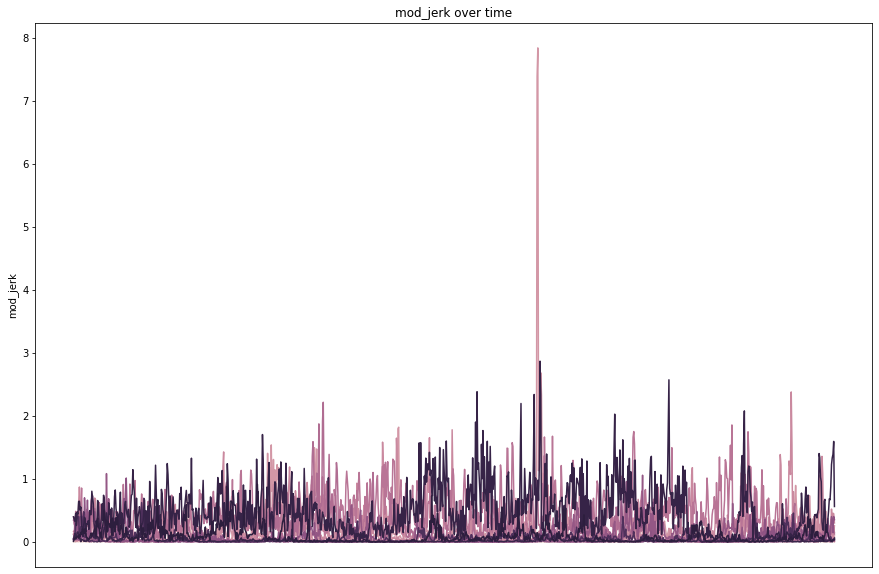

In [8]:
##### Acceleration module and jerk module variables over time
# To plot it faster, I choose 15 random ids

random_id = df_acc.loc[sample(range(0,len(df_acc.id_)),15)].id_.values
data = df_acc[df_acc.id_.isin(random_id)]

for var in ['mod_acc','mod_jerk']:
    plt.figure(figsize=(15, 10))
    plot = sns.lineplot('time_ref', var, data = data, hue = 'id_', legend=False)
    plt.title(f'{var} over time')
    plot.set(xlabel = None, xticklabels = [])
    plot.tick_params(bottom = False)
    plt.show()

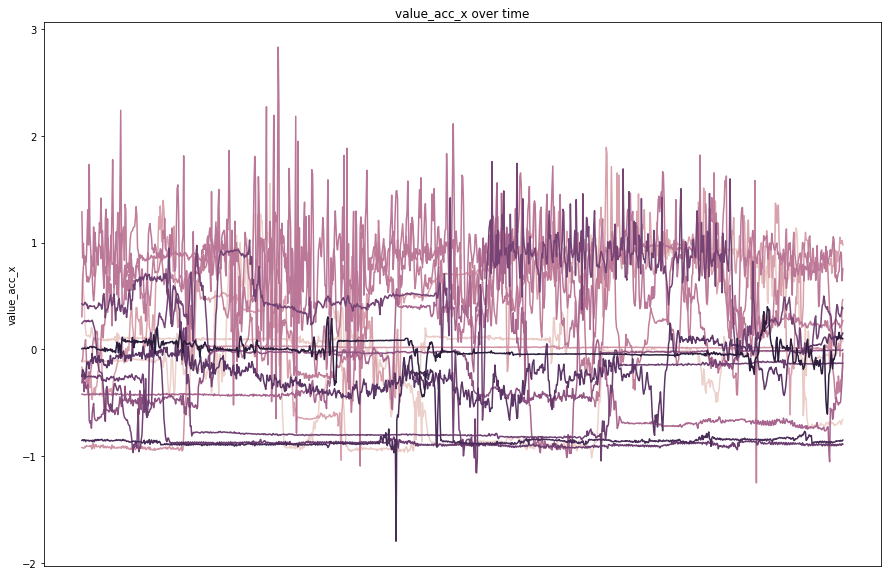

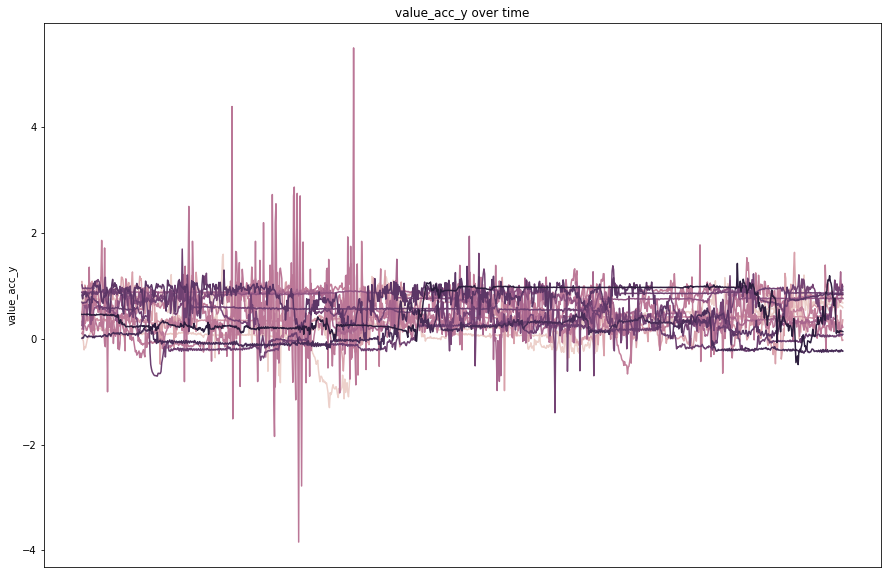

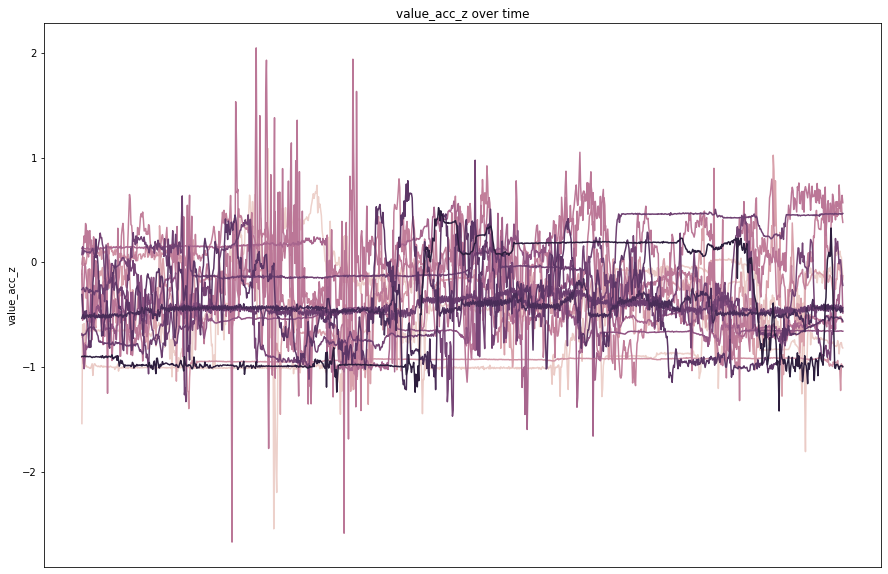

In [9]:
##### x/y/z-axis accelerometry over time
# To plot it faster, I choose 15 random ids

random_id = df_acc.loc[sample(range(0,len(df_acc.id_)),15)].id_.values
data = df_acc[df_acc.id_.isin(random_id)]

for var in ['value_acc_x','value_acc_y','value_acc_z']:
    plt.figure(figsize=(15, 10))
    plot = sns.lineplot('time_ref', var, data = data, hue = 'id_', legend=False)
    plt.title(f'{var} over time')
    plot.set(xlabel = None, xticklabels = [])
    plot.tick_params(bottom = False)
    plt.show()

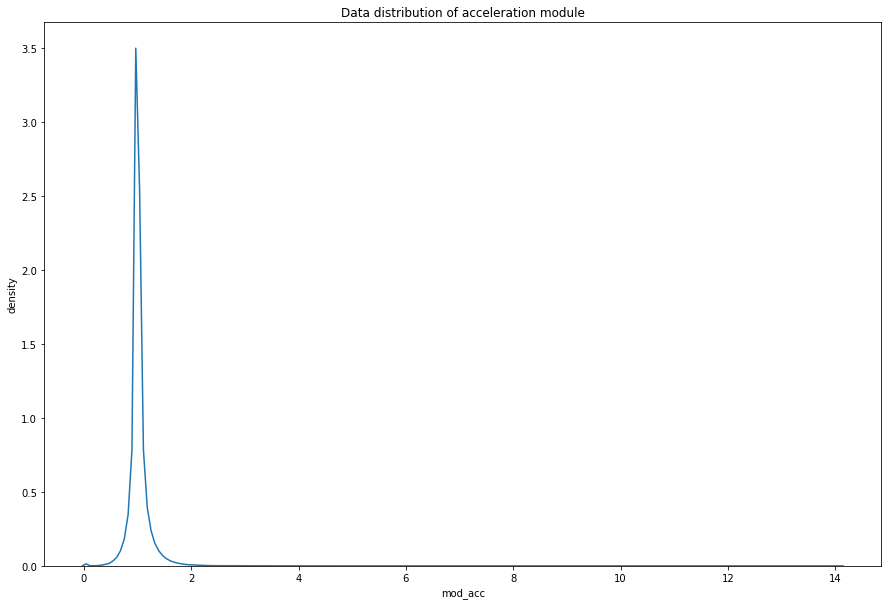

In [10]:
##### Data distribution of acceleration module
# There are extreme values but I'm not deleting it for now due to we can't conclude with this information that 
# there are errors in measurement (it might be related with the nature of such data).
# I must be careful with this because they can affect both the scoring and the model itself.

plt.figure(figsize=(15, 10))
sns.kdeplot(df_acc.mod_acc)
plt.xlabel("mod_acc")
plt.ylabel("density")
plt.title('Data distribution of acceleration module')
plt.show()

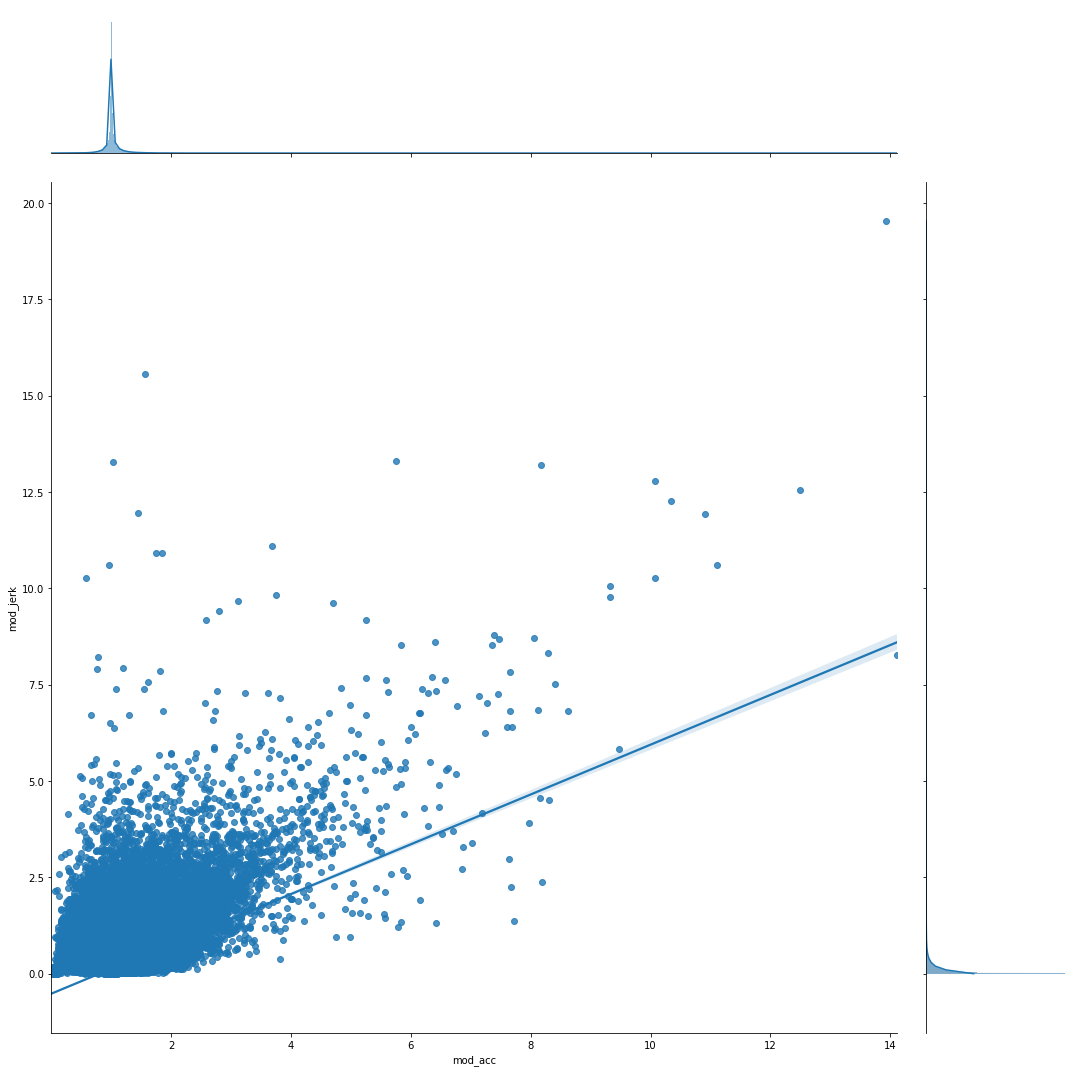

In [11]:
##### Relationship between acceleration module and jerk module

sns.jointplot(x = 'mod_acc', y = 'mod_jerk', data = df_acc, kind = 'reg', marginal_ticks = False, height = 15)
plt.show()

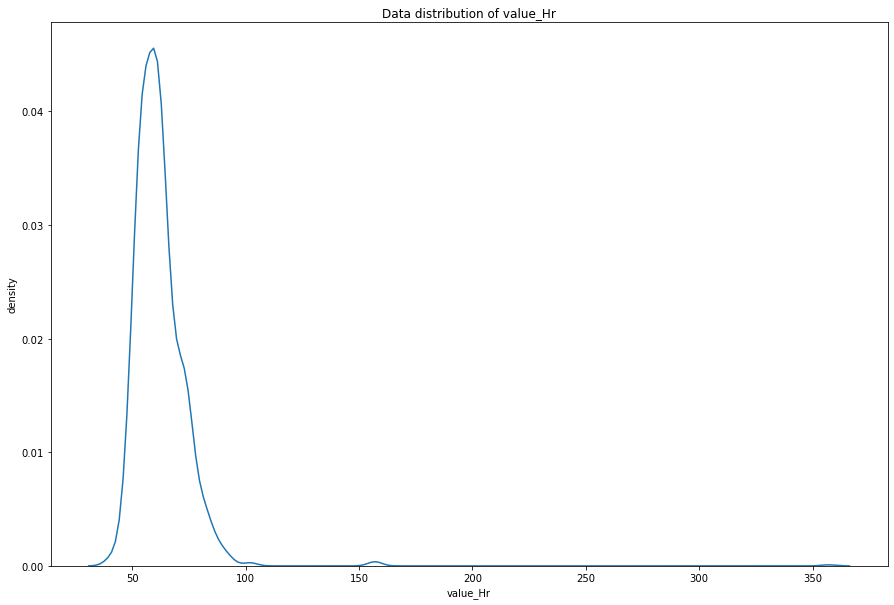

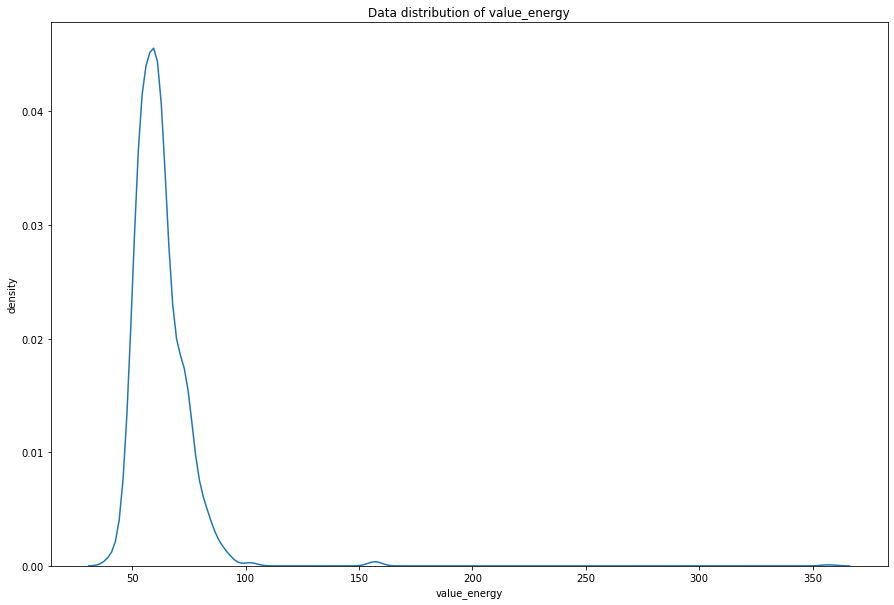

In [12]:
##### Data distribution of value_Hr and value_energy

for var in ['value_Hr', 'value_energy']:
    plt.figure(figsize=(15, 10))
    sns.kdeplot(df_energy['value_Hr'])
    plt.title(f'Data distribution of {var}')
    plt.xlabel(f'{var}')
    plt.ylabel('density')
    plt.show()

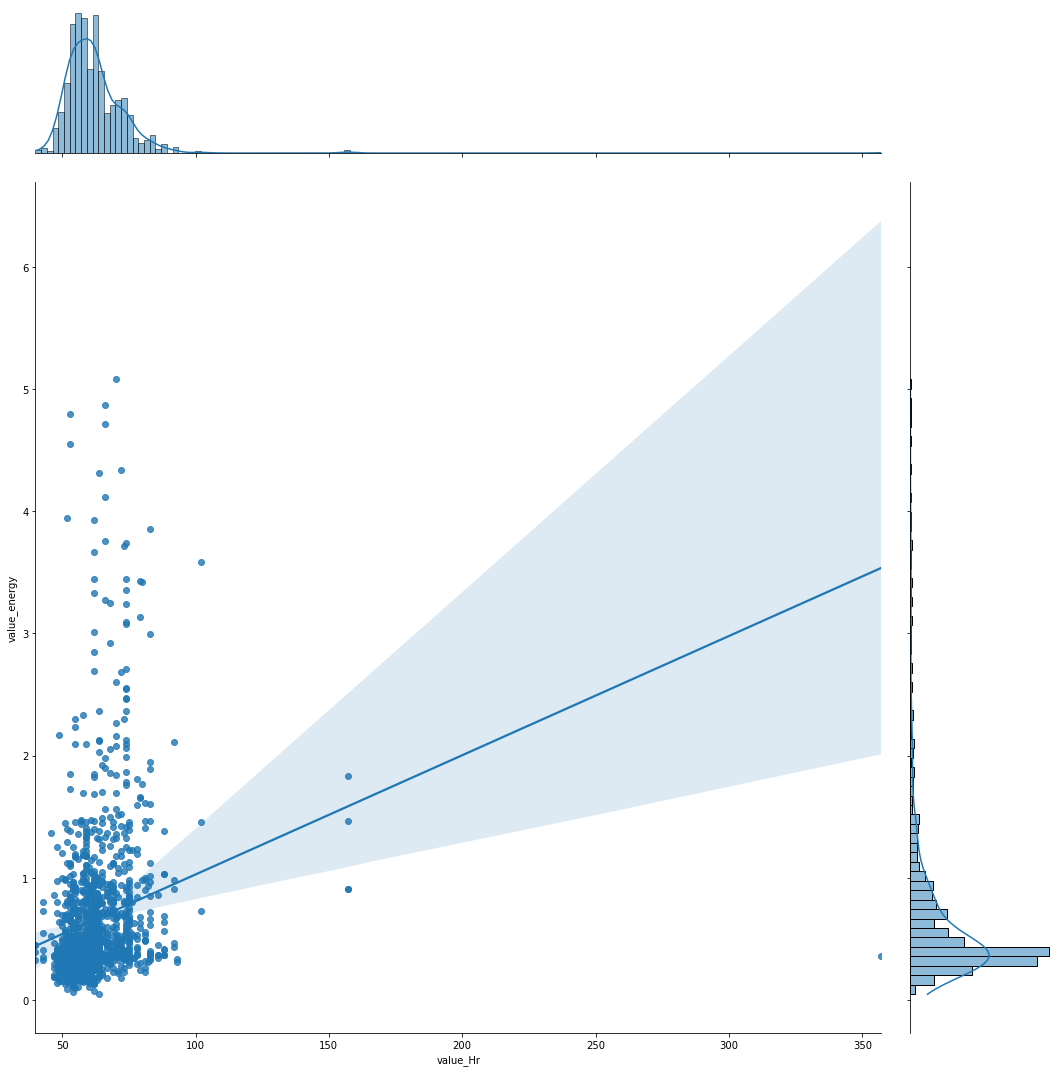

In [13]:
##### Relationship between value_Hr and value_energy

sns.jointplot(x = 'value_Hr', y = 'value_energy', data = df_energy, kind = 'reg', marginal_ticks = False, height = 15)
plt.show()

# Data Preparation

In [14]:
##### Data Preparation
# This is the key part of the exercise. By reason of only having information of the activity and heart rate just in time intervals of certain 
# individuals, the pulses are a unique value. Then, the better we collect all the information of thephysical activity performed,
# more information the model will have to achieve a better accuracy.
# A difference is made between two sets of variables:
#    1st: the objective is to collect the maximum possible information on the distribution of acceleration and
#    jerk per individual (mean, median, std, etc.)
#    2nd: the objective is the system of frequencies and moments thanks to the transformation.  It's understood that by the nature of the problem 
#    this transformation can help to extract more information from the physical activity.
#    We leave only one observation per id in order to train the model with the energy data.

df_acc_agg = df_acc.groupby("id_").agg({'mod_acc': [np.sum, percentile(25), percentile(75), np.mean, np.median],
                                        'mod_jerk':[np.sum, percentile(25), percentile(75), np.mean, np.median ]}).reset_index()
df_acc_agg.columns = ['_'.join(col).strip() for col in df_acc_agg.columns.values]   
df_acc_agg.rename(columns={"id__":"id_"},inplace=True)
df_acc_agg

,id_,mod_acc_sum,mod_acc_percentile_25,mod_acc_percentile_75,mod_acc_mean,mod_acc_median,mod_jerk_sum,mod_jerk_percentile_25,mod_jerk_percentile_75,mod_jerk_mean,mod_jerk_median
0,0,1043.220073,0.995411,1.009186,1.003096,1.004628,32.751422,0.008332,0.036585,0.031492,0.018499
1,1,1062.119013,0.995555,1.037425,1.021268,1.008131,148.592177,0.025989,0.186147,0.142877,0.082003
2,2,1047.105327,0.995010,1.007831,1.006832,1.000783,80.642615,0.014164,0.062698,0.077541,0.026917
3,3,1043.340073,0.994491,1.008151,1.003212,1.004660,28.341771,0.004286,0.020944,0.027252,0.009040
4,4,1050.852598,1.006196,1.011126,1.010435,1.009513,47.547551,0.004569,0.026014,0.045719,0.008492
...,...,...,...,...,...,...,...,...,...,...,...
1397,1397,1050.242694,0.995207,1.010991,1.009849,0.997482,126.172786,0.002457,0.154333,0.121320,0.036943
1398,1398,1029.323949,0.987261,0.991333,0.989735,0.989282,18.639718,0.004012,0.010716,0.017923,0.006141
1399,1399,1041.983537,0.997301,1.003573,1.001907,1.000854,31.715524,0.005222,0.018557,0.030496,0.008402
1400,1400,1037.054811,0.992046,0.999743,0.997168,0.995710,32.293950,0.006720,0.026404,0.031052,0.011644


In [15]:
##### Merge of both datasets and save for modelling notebook

df_acc_final = pd.merge(df_acc_agg, df_energy, how="inner", on="id_")
print('Saving dataset...')
df_acc_final.to_csv('df_final.csv', index = False)
print('Done!')

Saving dataset...
Done!
